In [1]:
import numpy as np
import pandas as pd
import re

# I. Données

In [2]:
corpus = pd.read_csv("./arxiv_articles.csv", sep="|")

Nous n'utilisons pas le corpus entier mais un sous-ensemble de celui-ci car il est trop long (41 062 documents).

In [3]:
nb_doc = 10000 # nombre de documents du corpus que l'on veut utiliser
corpus = corpus.loc[0:nb_doc, "summary"]

# II. Calcul du TF-IDF

## Fonctions pour le calcul du TF-IDF

In [4]:
def naif_regex_tokenize(text):
    """
    This is a very naif way of tokenize a text. Just using the
    regular expression "[a-z]" that will match any single word
    in lowercase.
    Returns a list with all the tokens.
    """
    p = re.compile("[a-z]+")
    return p.findall(text.lower())

def compute_tf(d):
    """
    Compute the tf for a given document d.
    The formula used is 
    
        tf(t, d) = 0.5 + 0.5 * (count(t, d)/max(count(t',d) for t' in d))
    
    This prevents bias in longer documents.
    """
    terms = pd.Series(naif_regex_tokenize(d))
    term_counts = terms.value_counts()
    max_tc = max(term_counts)
    return 0.5 + 0.5 * (term_counts / max_tc)

def compute_idf(D):
    """
    The input D is a list of pandas.Series
    having as each element, the term frequency 
    computed by the function compute_tf.
    """
    N = len(D)
    all_terms = pd.concat(D)
    nt = all_terms.index.value_counts() # The number of documents containing the term "t"
    return np.log(N / nt)

def compute_tf_idf_document(tf_document, idf):
    """Compute the tf-idf for each term in a document of the corpus

    Keyword arguments:
    tf_document -- list with the frequency of each term inside the document
    idf -- the idf value for each term in the corpus
    """
    return tf_document * np.array([idf[i] for i in tf_document.index])
    
def compute_tf_idf_corpus(D):
    """Compute the tf-idf for each term in a corpus

    Keyword arguments:
    D -- pandas Series containing a collection of documents in text format
    
    returns
        list of pandas Series containing the tf-idf(t, d, D) for each term
        inside each document of the corpus D
    """
    term_freq = [compute_tf(d) for d in D]
    idf = compute_idf(term_freq)
    return [compute_tf_idf_document(d, idf) for d in term_freq]

On peut obtenir la matrice des TF-IDF de chaque mot dans chaque document :

In [5]:
tf_idf = compute_tf_idf_corpus(corpus)

Puis la liste des TF-IDF de chaque mot :

In [6]:
all_terms = pd.concat(tf_idf)

## Utilisation d'un dictionnaire de "stop words" (mots vides)

Nous utilisons un dictionnaire de "stop words" afin de retirer les mots tels que "and", "the" ou encore "him" qui ne sont pas informatifs.

In [7]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
for i in stopwords.words('english'):
    if i in all_terms:
        all_terms.drop(index=[i], inplace=True)

## Moyenne des TF-IDF de chaque mot et classement des mots par TF-IDF

Un mot peut apparaître dans plusieurs documents. Il peut donc être associer à plusieurs valeurs de TF-IDF en fonction des documents. Pour pouvoir classer les mots en fonction de leur TF-IDF on fait donc tout d'abord la moyenne de tout les TF-IDF pour chaque mot.

In [9]:
mean_tf_idf = all_terms.groupby(all_terms.index).mean()

On peut maintenant classer les mots en fonction de la moyenne de leurs TF-IDF :

In [10]:
sorted_tf_idf = mean_tf_idf.sort_values(ascending=False)

# III. Dictionnaire des mots les plus informatifs

On considère par exemple qu'un mot qui est présent dans plus de 10 documents différents et qui a une forte valeur de TF-IDF est informatif. La fonction suivante permet de générer un dictionnaire de mots informatifs à partir d'un corpus D.

In [11]:
def dictionnaire(D, lenght_dico, K):
    dico=[]
    
    terms = []
    for d in D:
        terms += list(set(naif_regex_tokenize(d)))
    nt = pd.Series(terms).value_counts() # Le nombre de documents contenant le terme "t"
    
    for i in sorted_tf_idf.index:                           # On ajoute dans le dictionnaire les mots apparaissant dans plus
        if nt[i]>K and len(i)>1 and len(dico)<lenght_dico:  # de K documents et ayant le plus grand TF_IDF jusqu'à ce que le
            dico.append(i)                                  # dictionnaire soit plein ou qu'il n'y ai plus de mots
               
    return dico

Dans l'exemple suivant on génère un dictionnaire contenant les mots présent dans plus de 10 documents et ayant une forte valeur de TF-IDF. La taille du dictionnaire est inférieure ou égale à 100 mots.

In [144]:
dico = dictionnaire(corpus, 1000, 143)
print(dico)

['logic', 'web', 'pulsars', 'polarization', 'agn', 'neutron', 'disc', 'graph', 'international', 'package', 'risk', 'programs', 'pulsar', 'demand', 'rm', 'digital', 'bounds', 'analytic', 'life', 'content', 'wind', 'memory', 'theorem', 'bursts', 'unit', 'structural', 'notion', 'double', 'property', 'extension', 'mu', 'metallicity', 'length', 'generalized', 'stage', 'cherenkov', 'timing', 'detectors', 'architecture', 'overview', 'agent', 'convergence', 'polynomial', 'price', 'weighted', 'utility', 'rule', 'redshift', 'log', 'uniform', 'solving', 'air', 'constructed', 'aspects', 'define', 'companion', 'training', 'semi', 'candidates', 'minimum', 'researchers', 'product', 'bands', 'dense', 'characterization', 'published', 'waves', 'map', 'analytical', 'orders', 'distances', 'upon', 'conditional', 'integrated', 'measures', 'tasks', 'represent', 'maps', 'game', 'varying', 'five', 'modelling', 'date', 'pressure', 'stability', 'brightness', 'agents', 'abundance', 'calculations', 'detail', 'astr

In [145]:
len(dico)

1000

# IV. Feature extraction

## Vectorisation

On utilise les termes du dictionnaire afin de créer, pour chaque document, un vecteur TF-IDF. Ce vecteur aura les valeurs du TF-IDF de chaqu'un des termes. Par exemple, si la liste de termes est ["float", "genetic", "circular"] et qu'on a 4 document. On doit produire une matrice de 4 lignes et 3 colonnes :
```
0.1 5.8 9
4.7 1.0 3
8.0 2.4 6.0
0.3 9.1 3.2
```   
Ici, chaque ligne contient les valeurs de *tf-idf* de ["float", "genetic", "circular"] (dans cet ordre)

In [146]:
def vectorizer(D,dico):
    matrice = np.zeros((len(D),len(dico)))

    tf_idf = compute_tf_idf_corpus(D)
    
    for d in range(len(D)):
        text_to_list = naif_regex_tokenize(D[d])
        for t in range(len(dico)):
            if dico[t] in text_to_list:
                matrice[d][t]=tf_idf[d][dico[t]]
                
    return matrice

In [147]:
matrice = vectorizer(corpus, dico)

On transforme ensuite cette matrice en matrice creuse afin qu'elle prenne moins de place en mémoire.

In [148]:
from scipy import sparse

matrice_csr = sparse.csr_matrix(matrice)

## Normalisation

Nous allons maintenant normaliser les lignes de cette matrice. Cette étape permet de meilleurs résultats pour l'algorithme des K-means qui va suivre.
La norme 2 des vecteurs TF-IDF représentés par chaque ligne doit être 1.

In [149]:
from sklearn.preprocessing import normalize

matrix_normalized = normalize(matrice_csr, norm='l2', axis=1)
matrice_finale = matrix_normalized.toarray()
print(matrice_finale)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.06151802]
 [0.         0.         0.         ... 0.         0.         0.        ]]


# V. K-means

In [150]:
# Paramètre
k=8

In [151]:
def distance(v1, v2):
    """
    Compute the distance between v1 and v2
    v1 and v2 are numpy arrays
    """
    return np.sqrt(np.sum((v1-v2)**2))

def assign(vectors, centers):
    """
    assign each vector to the closest center.
    vectors is a numpy matrix. We want to assign each
    row to the closest center.
    centers is a numpy matrix. Each row has a center
    
    returns a list of integers. 
    One value for each vector indicating the closest center
    """
    groups = np.zeros(vectors.shape[0])
    for i in range(len(groups)):
        groups[i] = np.argmin(np.apply_along_axis(distance, 1, centers, vectors[i]))
    return groups

def compute_centers(vectors, groups):
    """
    Compute the centers for each group of 
    vectors
    vectors is a numpy matrix
    groups is a list containing the assignments
    of the vectors
    """
    new_centers = np.zeros([int(max(groups)) + 1, vectors.shape[1]])
    for i in range(int(max(groups)) + 1):
        ix = np.where(groups==i)[0]
        grp_members = vectors[ix, :]
        new_centers[i] = grp_members.mean(0)
    return new_centers

def choose_first_centers(vectors, k):
    """
    Select the first k centers for the begining of the
    k-means algorithm
    """
    ix = np.arange(0, vectors.shape[0])
    np.random.shuffle(ix)
    return vectors[ix[:k], :]

def kmeans(vectors, k, max_iterations = 500):
    """
    Naive implementation of k-means algorithm
    """
    centers_list = []
    centers = choose_first_centers(vectors, k)
    centers_list.append(centers)
    groups = assign(vectors, centers)
    new_centers = compute_centers(vectors, groups)
    centers_list.append(new_centers)
    nb_iter = 0
    while (np.sum(np.abs(centers - new_centers)) > 0) or (nb_iter > max_iterations):
        centers = np.copy(new_centers)
        groups = assign(vectors, centers)
        new_centers = compute_centers(vectors, groups)
        centers_list.append(new_centers)
        nb_iter += 1
    return new_centers, centers_list


In [152]:
centers, centers_list = kmeans(matrice_finale, k)
centers

array([[0.00019013, 0.00169111, 0.00551591, ..., 0.01783915, 0.01074531,
        0.02515515],
       [0.00220966, 0.00073618, 0.000176  , ..., 0.01874797, 0.02492312,
        0.01641485],
       [0.        , 0.00137891, 0.01193273, ..., 0.01642428, 0.01287278,
        0.01893995],
       ...,
       [0.01438069, 0.00057641, 0.        , ..., 0.01544192, 0.02891638,
        0.01042481],
       [0.        , 0.        , 0.        , ..., 0.02184939, 0.03084578,
        0.02058827],
       [0.01197778, 0.01732259, 0.        , ..., 0.01588779, 0.03312223,
        0.0198688 ]])

# Tri des documents en fonction du résultat de l'algorithme k-means

In [153]:
Docs=[]                           # Création d'une série pandas contenant le numéro des documents associés à chaque cluster
Index=[]
for i in range(k):
    Index += ["cluster "+str(i)]
    Docs += [[]]
tri=pd.Series(Docs,index=Index)

Assign=assign(matrice_finale, centers) # Grâce à la fonction assign qui assigne chaque vecteur au centre le plus proche,
for doc in range(len(Assign)):         # on remplit cette série  
    for cluster in range(k):
        if int(Assign[doc])==cluster:
            Docs[cluster]+=[doc]

print(tri)

cluster 0    [10, 14, 35, 57, 74, 111, 150, 186, 188, 189, ...
cluster 1    [115, 213, 299, 300, 358, 377, 456, 613, 614, ...
cluster 2    [892, 1099, 1991, 2261, 5175, 5178, 5180, 5182...
cluster 3    [276, 5181, 5190, 5191, 5202, 5217, 5223, 5230...
cluster 4    [1688, 5179, 5188, 5205, 5220, 5221, 5274, 529...
cluster 5    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15,...
cluster 6    [216, 700, 977, 1057, 1359, 1391, 1397, 1564, ...
cluster 7    [45, 101, 133, 337, 480, 522, 558, 668, 703, 7...
dtype: object


<BarContainer object of 8 artists>


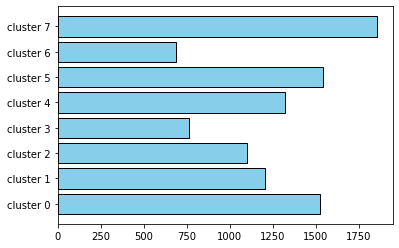

In [156]:
# Nombre de documents par cluster
import matplotlib.pyplot as plt
taille=[]
for i in tri.index:
    taille+=[len(tri[i])]
    
print(plt.barh(tri.index, taille, color="skyblue", edgecolor="black"))

In [155]:
# Titre/Catégorie du cluster
# Mot le plus représentatif du cluster (Mot avec le plus grand TF-IDF)

c = 0
for centre in centers:
    indices=[i for i,x in enumerate(centre) if x==max(centre)]
    print("Cluster",c,":", dico[indices[0]])
    c+=1

Cluster 0 : method
Cluster 1 : market
Cluster 2 : telescope
Cluster 3 : ray
Cluster 4 : mass
Cluster 5 : prove
Cluster 6 : estimation
Cluster 7 : paper
